In [1]:
import nest_asyncio
nest_asyncio.apply()

import pyshark
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import stats

def get_time_secs(packet, start_time):
    time = packet.sniff_time-start_time
    time = time.seconds+time.microseconds/1e6
    return time

# set filename(s) to scan
script_dir = os.path.dirname(os.path.abspath("."))
base_dir = os.path.abspath(script_dir + '/../measurement/data/maindata')
filenames = ['1202/output_ping_new_overnight.pcapng',
             '1204/output_whole_prefix_overnight.pcapng',
             '1205/overnight_whole_2alter_prefix.pcapng']
filenames = [base_dir + '/' + f for f in filenames]
filename = filenames[2]

# set filter for wireshark capture
disp_filter = 'ip and !dns'

# relevant ip addresses
echo_ip = '10.42.0.159'
pi_ip = '172.19.222.76'
server_ip = '52.119.197.96'
ping1_ip = '1.1.1.1'
ping2_ip = '8.8.4.4'
ping3_ip = '8.8.8.8'
ping4_ip = '9.9.9.9'

In [2]:
#%%
## BREAK DATA INTO TEST FRAMES
# Each test frame contains packet times and sizes, split by either
# source or destination address
cap = pyshark.FileCapture(filename, display_filter=disp_filter)
start_time = cap[0].sniff_time

out_times = [] # out_times[frame][dst_addr_index] gives list of packet times
out_sizes = [] # out_sizes[frame][dst_addr_index] gives list of packet sizes
out_dsts = [] # out_dsts[frame] gives list of destination addresses
in_times = [] # in lists follow same convention as out lists
in_sizes = []
in_srcs = []

in_frame = 0 # boolean indicating whether we are in a test frame or not
frame = 0 # current test frame number
for n,p in enumerate(cap):
    # start a test frame (on start of recording playback)
    if p.ip.src == pi_ip and p.ip.dst == ping1_ip:
        print('Start: {}, {}'.format(n, p.number))
        assert in_frame == 0
        in_frame = 1
        
        # add frame to list
        out_times.append([])
        out_sizes.append([])
        out_dsts.append([])
        # add ping destination to list (to make visualization easier)
        out_dsts[frame].append(p.ip.dst)
        out_times[frame].append([])
        out_sizes[frame].append([])
        # add ping packet to list
        i = len(out_dsts[frame]) - 1
        out_times[frame][i].append(get_time_secs(p, start_time))
        out_sizes[frame][i].append(1000)
        print(get_time_secs(p, start_time))
        #add frame to list
        in_times.append([])
        in_sizes.append([])
        in_srcs.append([])
        # add ping destination to list (to make visualization easier)
        in_srcs[frame].append(p.ip.dst)
        in_times[frame].append([])
        in_sizes[frame].append([])
        # add ping packet to list
        i = len(in_srcs[frame]) - 1
        in_times[frame][i].append(get_time_secs(p, start_time))
        in_sizes[frame][i].append(1000)
    
    # end a test frame (on start of echo reply)
    if p.ip.src == pi_ip and p.ip.dst == ping3_ip:
        print('End: {}, {}'.format(n, p.number))
        if in_frame != 1:
            print("Frame end encountered before start, skipping")
            continue
        in_frame = 0

        # add ping destination to list (to make visualization easier)
        out_dsts[frame].append(p.ip.dst)
        out_times[frame].append([])
        out_sizes[frame].append([])
        # add ping packet to list
        i = len(out_dsts[frame]) - 1
        out_times[frame][i].append(get_time_secs(p, start_time))
        print(get_time_secs(p, start_time))
        out_sizes[frame][i].append(1000)

        # add ping destination to list (to make visualization easier)
        in_srcs[frame].append(p.ip.dst)
        in_times[frame].append([])
        in_sizes[frame].append([])
        # add ping packet to list
        i = len(in_srcs[frame]) - 1
        in_times[frame][i].append(get_time_secs(p, start_time))
        in_sizes[frame][i].append(1000)

        frame = frame + 1
        if frame >= 10:
            break
    
    if p.ip.src == pi_ip and p.ip.dst == ping2_ip:
        print('End: {}, {}'.format(n, p.number))
        if in_frame != 1:
            print("Frame end encountered before start, skipping")
            continue
        print(get_time_secs(p, start_time))

    # record data for test frame (on ssl packets)
    if in_frame and p.highest_layer == 'TLS' \
       and 'record_length' in p.tls.field_names:
        # handle outgoing packets
        if p.ip.src == echo_ip:
            # get dst index if dst exists on list, otherwise add dst to list
            try:
                i = out_dsts[frame].index(p.ip.dst)
            except:
                out_dsts[frame].append(p.ip.dst)
                out_times[frame].append([])
                out_sizes[frame].append([])
                i = len(out_dsts[frame]) - 1
            # add packet to list
            out_times[frame][i].append(get_time_secs(p, start_time))
            out_sizes[frame][i].append(int(p.tls.record_length))
        # handle incoming packets
        elif p.ip.dst == echo_ip:
            # get src index if src exists on list, otherwise add src to list
            try:
                i = in_srcs[frame].index(p.ip.src)
            except:
                in_srcs[frame].append(p.ip.src)
                in_times[frame].append([])
                in_sizes[frame].append([])
                i = len(in_srcs[frame]) - 1
            # add packet to list
            in_times[frame][i].append(get_time_secs(p, start_time))
            in_sizes[frame][i].append(int(p.tls.record_length))


Start: 29, 60
12.165616
End: 394, 450
23.481921
End: 732, 794
25.291428
Start: 1305, 1799
148.791951
End: 1618, 2125
151.100059
End: 2019, 2533
153.182651
Start: 2365, 3291
276.597609
End: 2742, 3714
287.913223
End: 3083, 4066
289.691189
Start: 3542, 4924
413.422051
End: 3870, 5266
415.726245
End: 4282, 5681
417.720181
Start: 4693, 6547
541.478509
End: 5083, 6987
552.794235
End: 5423, 7336
555.608265
Start: 5754, 8048
678.973643
End: 6101, 8402
681.281262
End: 6535, 8856
683.124998
Start: 6972, 9691
806.556002
End: 7348, 10110
817.872257
End: 7687, 10458
819.692157
Start: 8007, 11114
943.35948
End: 8346, 11470
945.661557
End: 8688, 11815
947.506314
Start: 9196, 12806
1071.212686
End: 9571, 13230
1082.529953
End: 9944, 13609
1084.64011
Start: 10269, 14367
1206.298188
End: 10591, 14703
1208.602953
End: 10919, 15037
1210.479395


/Users/alex/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


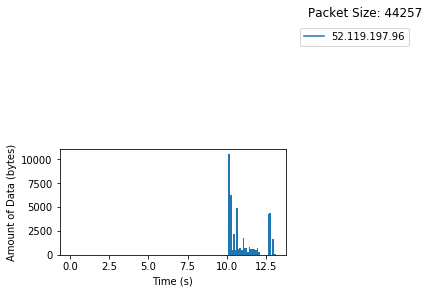

0 44257


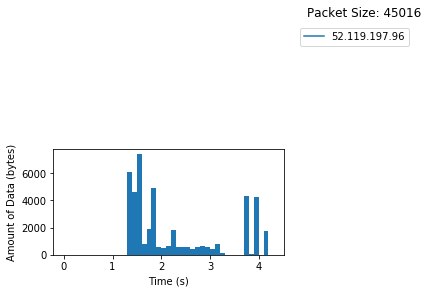

1 45016


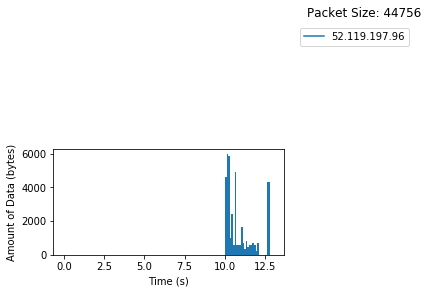

2 44756


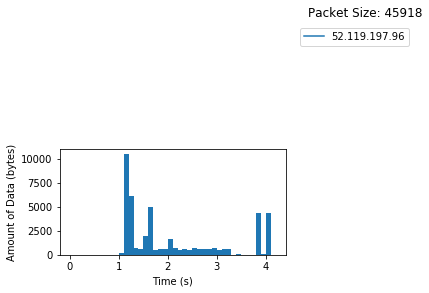

3 45918


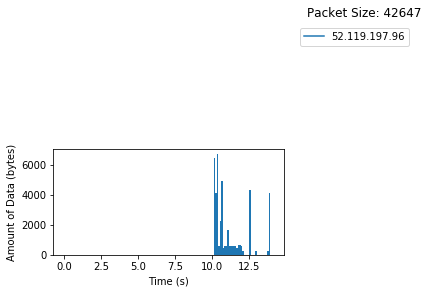

4 42647


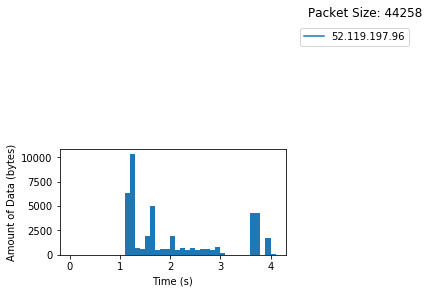

5 44258


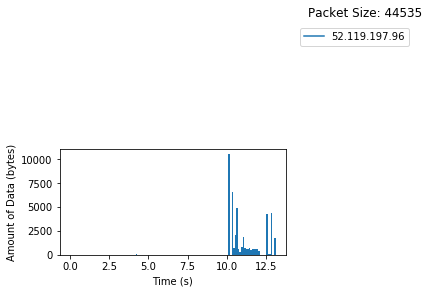

6 44535


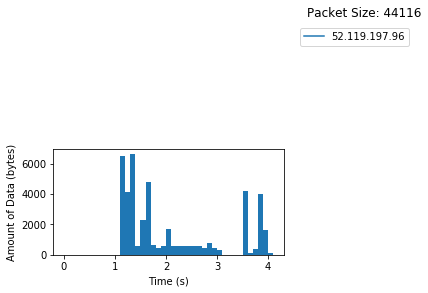

7 44116


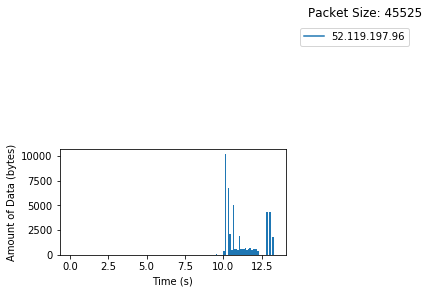

8 45525


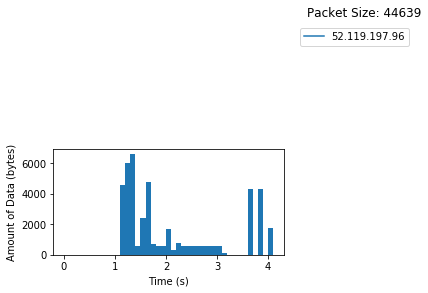

9 44639


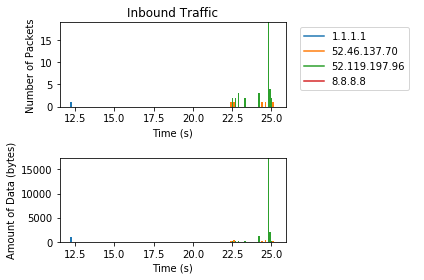

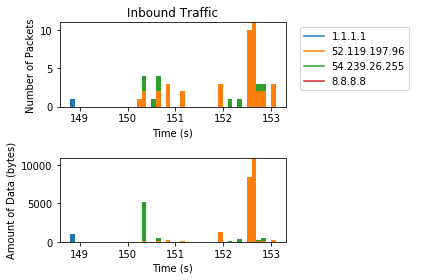

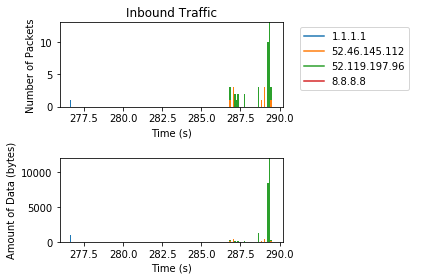

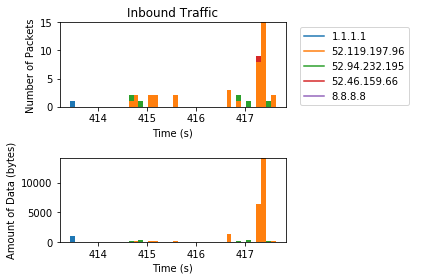

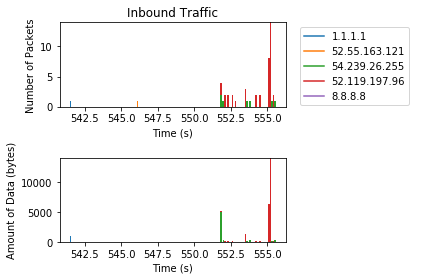

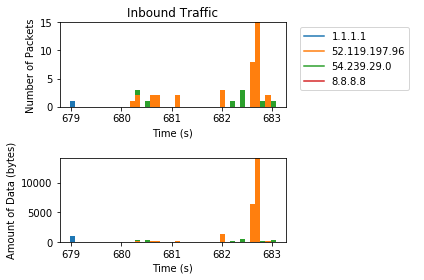

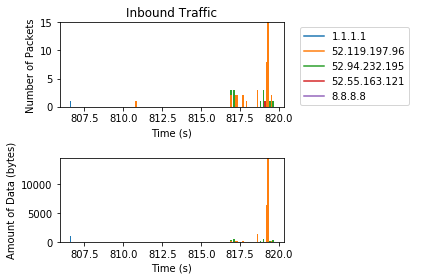

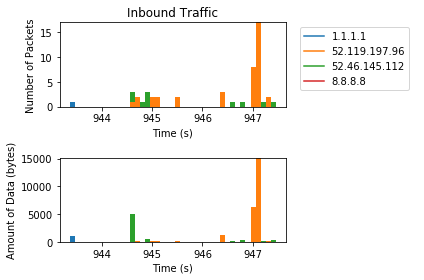

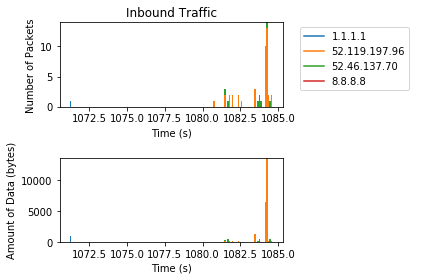

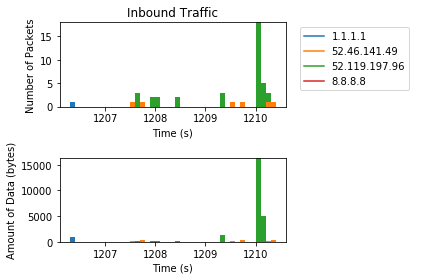

In [5]:
#%%
## PLOT OUTGOING DATA BY FRAME
ttl_packet_sizes = []
for frame in range(len(out_times)):
    #if frame != 88:
       # continue
    #frame = 200 - frame
    times_plot = out_times[frame][:]
    sizes_plot = out_sizes[frame][:]
    dsts_plot = out_dsts[frame][:]
    
    #if frame <= 150:
        #break
        #print(times_plot)
        #print(sizes_plot)
        #print(dsts_plot)
        
    #print(times_plot)
    #print(sizes_plot)
    #print(dsts_plot)
    #main ip: 52.94.233.109
    if "52.119.197.96" in dsts_plot:
        idx_of_main = dsts_plot.index("52.119.197.96")
    elif "54.239.18.66" in dsts_plot:
        idx_of_main = dsts_plot.index("54.239.18.66")
        
    # Get relative range
    min_range = 0
    max_range = np.max(np.max(times_plot)) - np.min(np.min(times_plot))
    
    # set bin size at 100 ms
    bins = np.arange(min_range,max_range, 0.1)
    
    adjusted_times_plot = times_plot[idx_of_main]-np.min(np.min(times_plot))
    
    filtered_adjusted_times_plot = []
    filtered_sizes_plot = []
    # Filter packets that are sent before command is over
    discard_sample_point = False
    started_main_data = False
    main_data_count = 0
    previous_time = adjusted_times_plot[0]
    for times, sizes in zip(adjusted_times_plot, sizes_plot[idx_of_main]):
        #if times <= 9 and sizes >= 2000 and max_range >= 10:
            #discard_sample_point = True
        #if times <= 9 and sizes >= 2000 and max_range <= 5:
            #discard_sample_point = True
            
#         if times - previous_time >= 0.2:
#             if started_main_data ==True:
#                 break
#             else:
#                 pass
#         else:
#             main_data_count += 1
#             if main_data_count >= 10:
#                 started_main_data = True
            
        previous_time = times
        filtered_adjusted_times_plot.append(times)
        filtered_sizes_plot.append(sizes)
    
    #discard_sample_point = False
    #if discard_sample_point == True:
        #continue
        
    plt.figure()
    # create histogram of packet counts
    # weird subplot stuff is for formatting reasons
    #plt.subplot2grid((2,3),(0,0), colspan=2)
    #plt.hist(times_plot, bins=bins, stacked=True)
    #plt.title('Outbound Traffic')
    #plt.ylabel('Number of Packets')
    #plt.xlabel('Time (s)')
    
    # create histogram of packet sizes
    plt.subplot2grid((2,3),(1,0), colspan=2)
    plt.hist(filtered_adjusted_times_plot, bins=bins, weights=filtered_sizes_plot, stacked=True)
    plt.ylabel('Amount of Data (bytes)')
    plt.xlabel('Time (s)')
    ttl_packet_sizes.append(sum(filtered_sizes_plot))
    
    # create legend of destination addresses off to the side
    plt.subplot2grid((2,3),(0,2), rowspan=2)
    for x in out_times:
        plt.plot(0,0)
        plt.xticks([])
        plt.yticks([])
        plt.box('off')
    plt.legend(dsts_plot[idx_of_main:idx_of_main+1])
    plt.tight_layout()
    plt.title("Packet Size: {}".format(sum(filtered_sizes_plot)))
    plt.show()
    #if frame >= 42:
        #print(times_plot)
        #print(sizes_plot)
        #print(dsts_plot)
    print(frame, sum(filtered_sizes_plot))

#ttl_packet_sizes = ttl_packet_sizes[2:]
#prefix = ttl_packet_sizes[1::2]
#no_prefix = ttl_packet_sizes[::2]
#print(prefix)
#print(no_prefix)



In [ ]:
np.random.seed(12345678)
prefix = ttl_packet_sizes[1::2]
no_prefix = ttl_packet_sizes[::2]

prefix = [i for i in prefix if i >= 10000]
no_prefix = [i for i in no_prefix if i>= 10000]
print(prefix)
print(no_prefix)
from scipy import stats
import numpy as np
print(stats.ttest_ind(prefix,no_prefix,equal_var = False))
print(stats.ttest_ind(prefix,no_prefix,equal_var = True))



In [ ]:
# %%
## CALCULATE STATISTICS PER TEST FRAME
total_size_out = []
total_size_in = []

# get sum of data for each test frame
for x in out_sizes:
    total_size_out.append(np.sum(np.sum(x)))
for x in in_sizes:
    total_size_in.append(np.sum(np.sum(x)))

# do some filtering (z-value method)
# def filt(x, z):
#     if z < 3:
#         return x
#     else:
#         return np.nan

# z_out = np.abs(stats.zscore(total_size_out))
# total_size_out_filt = [filt(x,z) for z,x in zip(z_out, total_size_out)]
# z_in = np.abs(stats.zscore(total_size_in))
# total_size_in_filt = [filt(x,z) for z,x in zip(z_in, total_size_in)]

# do some filtering (IQR method)
def filt(x, q1, q3, iqr):
    if x > q1-1.5*iqr and x < q3+1.5*iqr:
        return x
    else:
        return np.nan

q1_out = np.quantile(total_size_out, 0.25)
q3_out = np.quantile(total_size_out, 0.75)
iqr_out = q3_out-q1_out
total_size_out_filt = [filt(x, q1_out, q3_out, iqr_out) for x in total_size_out]

q1_in = np.quantile(total_size_in, 0.25)
q3_in = np.quantile(total_size_in, 0.75)
iqr_in = q3_in-q1_in
total_size_in_filt = [filt(x, q1_in, q3_in, iqr_in) for x in total_size_in]


# plot total data size for all test frames
plt.figure()
plt.subplot(2,1,1)
plt.plot(total_size_out_filt, '*')
# plt.ylim(40000,75000)
plt.xlabel('Test number')
plt.ylabel('Outgoing data size (bytes)')
plt.subplot(2,1,2)
plt.plot(total_size_in_filt, '*')
plt.xlabel('Test number')
plt.ylabel('Incoming data size (bytes)')
plt.tight_layout()
plt.show()

# # plot histograms
num_bins = 20
plt.figure()
plt.subplot(2,1,1)
plt.hist(total_size_out_filt, num_bins)
plt.xlabel('Outgoing data size (bytes)')
plt.ylabel('Frequency')
plt.subplot(2,1,2)
plt.hist(total_size_in_filt, num_bins)
plt.xlabel('Incoming data size (bytes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


# %%
## STATISTICS BY PREFIX LENGTH
# num_tests = 19
# prefix_times = 9 - np.linspace(0, 9, num_tests) # 0.5s spacing
# prefix_times = np.roll(prefix_times, -1)
num_tests = 2
prefix_times = [9,0]

# calculate mean and std across each prefix length (stride across data)
means_out = []
stds_out = []
means_in = []
stds_in = []
for i in range(num_tests):
    means_out.append(np.nanmean(total_size_out_filt[i::num_tests]))
    stds_out.append(np.nanstd(total_size_out_filt[i::num_tests]))
    means_in.append(np.nanmean(total_size_in_filt[i::num_tests]))
    stds_in.append(np.nanstd(total_size_in_filt[i::num_tests]))

# plot average size with error bars against prefix length
plt.figure()
plt.errorbar(prefix_times, means_out, yerr=stds_out, fmt='*')
plt.xlabel('Prefix Time (s)')
plt.ylabel('Average Outgoing Data Size (bytes)')
plt.show()

plt.figure()
plt.errorbar(prefix_times, means_in, yerr=stds_in, fmt='*')
plt.xlabel('Prefix Time (s)')
plt.ylabel('Average Incoming Data Size (bytes)')
plt.show()



# %%